## Work with Images


### By now, we are familiar ourself with number of machine learning algorithms along with the applications in numerical data. Let's turn to another application of machine learning - Image processing. In previous subsection, we discussed a few popular techniques in unsupervised learning, such as PCA, Isomap in dimensionality reduction, K-Means, GMM in clustering. Let's start performing these techniques in image, for now, we are using sklearn's images dataset. Later on, we will show you how to load and train algorithms with the images from your local disk.


### For this exercise, we will be using Labelled Faces in the Wild(LFW) people datasets, it collects pictures of famous people in JPEG. Detail available at \url{http://vis-www.cs.umass.edu/lfw/http://vis-www.cs.umass.edu/lfw/}


In [4]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


In [169]:
from sklearn.datasets import fetch_lfw_people 
face_data = fetch_lfw_people()
print(face_data.data.shape)
for name in face_data.target_names:
     print(name)

(146, 2914)
Arminio Fraga
Bob Huggins
Colin Montgomerie
Curtis Strange
Darren Clarke
Fernando Leon de Aranoa
George HW Bush
Gloria Macapagal Arroyo
John Manley
Larry Ellison
Marc Grossman
Michael Schumacher
Mstislav Rostropovich
Nelson Mandela
Paul Lo Duca
Paul ONeill
Tiger Woods


### We have now 146 images, and each with 2,914 pixels. A pixel is a single element of in a digital picture, simply put, we can thought of as data point in a 2,914-dimensional space. 

In [6]:
def show_batch(image_batch ):
  plt.figure(figsize=(7,5))
  for i in range(24):
      ax = plt.subplot(4,6,i+1)
      plt.imshow(image_batch[i],cmap='gray')
      plt.axis('off')

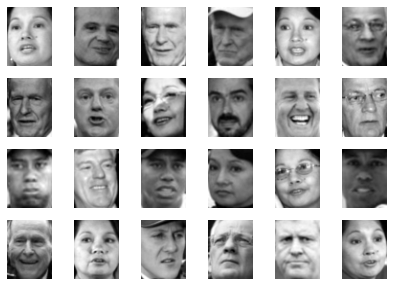

In [5]:
show_batch(face_data.images )
#plt.savefig('faces.png', dpi=72, bbox_inches='tight')

In [7]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
isomap_face = model.fit_transform(face_data.data)
isomap_face.shape

(146, 2)

In [9]:
data_num = isomap_face.shape[0]
data_count = list( range(data_num))
count_ind = data_count[0::2]
from matplotlib import offsetbox

def plotting_out(data, model, images=None, ax=None,cmap='gray'):
    ax = ax or plt.gca()
    model_pred = model.fit_transform(data)
    ax.plot(model_pred[:, 0], model_pred[:, 1], '.')
    for i in count_ind:
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i], cmap=cmap), model_pred[i])
        ax.add_artist(imagebox)

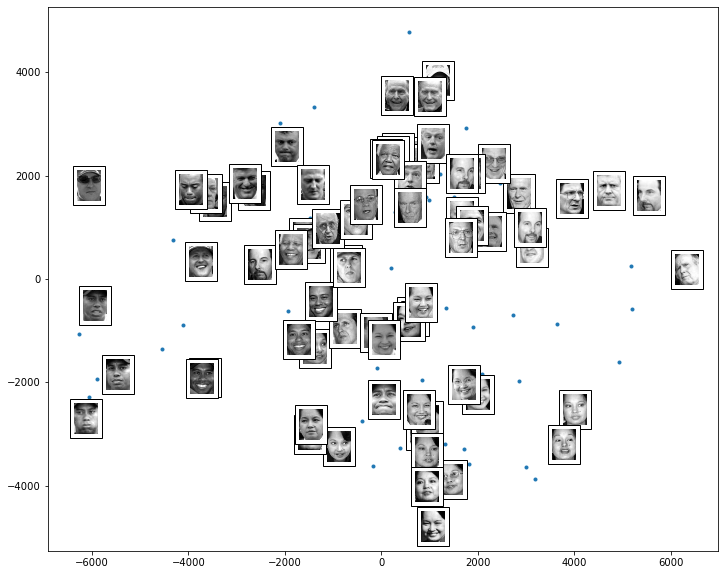

In [11]:

fig, ax = plt.subplots(figsize=(12, 10))
plotting_out(face_data.data,
                model=Isomap(n_components=2),
                images=face_data.images[:, ::2, ::2])
#plt.savefig('faces_isomap.png', dpi=72, bbox_inches='tight')

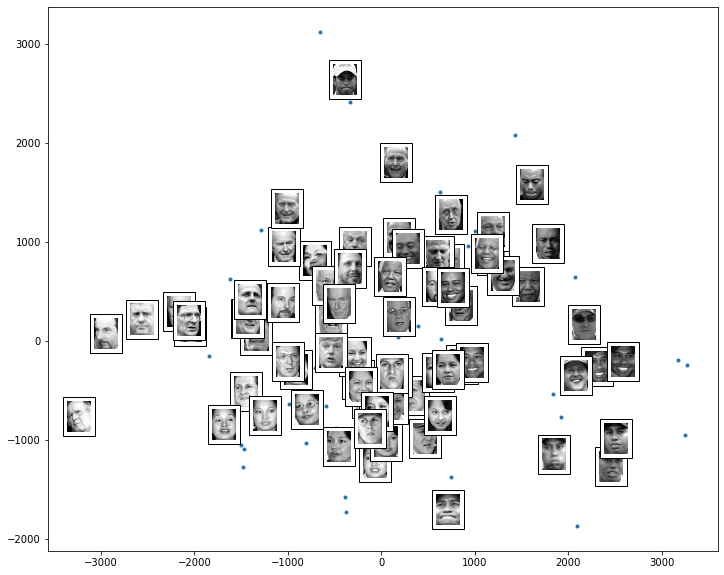

In [12]:
from sklearn.decomposition import PCA 
fig, ax = plt.subplots(figsize=(12, 10))
plotting_out(face_data.data,
                model=PCA(n_components=2),
                images=face_data.images[:, ::2, ::2])
#plt.savefig('faces_PCA.png', dpi=72, bbox_inches='tight')

## Convolutional Neural Network

In [309]:
from sklearn.datasets import fetch_lfw_people 
face_data = fetch_lfw_people(min_faces_per_person=20, resize=0.3)
print(face_data.data.shape)
for name in face_data.target_names:
     print(name)
        
x= face_data.data
n_features = x.shape[1]
print("number of features: %d" % n_features)


y = face_data.target
target_names = face_data.target_names
n_classes = target_names.shape[0]
print("number of people: %d" % n_classes)


(67, 1036)
Gloria Macapagal Arroyo
Tiger Woods
number of features: 1036
number of people: 2


In [312]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42)


x_train = X_train.astype('float32') 
x_test = X_test.astype('float32') 
x_train /= 255 
x_test /= 255 




print(x_train.shape)
print(face_data.images.shape)


(60, 1036)
(67, 37, 28)


In [313]:
im_shape = (37, 28,1)
X_train = X_train.reshape(X_train.shape[0], *im_shape)
X_test = X_test.reshape(X_test.shape[0], *im_shape)
X_test.shape

(7, 37, 28, 1)

In [322]:

import tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

model= Sequential([
    Conv2D(filters=64, kernel_size=3, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=24, kernel_size=3, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(2, activation='softmax')  
])


model.compile(loss = tensorflow.keras.losses.sparse_categorical_crossentropy, 
   optimizer =tensorflow.keras.optimizers.Adadelta(), metrics = ['accuracy'])

print(model.summary())



Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 35, 26, 64)        640       
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 17, 13, 64)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 15, 11, 24)        13848     
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 7, 5, 24)          0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 840)               0         
_________________________________________________________________
dense_172 (Dense)            (None, 10)                8410      
_________________________________________________________________
dense_173 (Dense)            (None, 2)               

In [321]:
history = model.fit(
   np.array(X_train), np.array(y_train),
   batch_size = 50, 
   epochs = 50, verbose=2, validation_data = (X_test, y_test),
)

Train on 60 samples, validate on 7 samples
Epoch 1/50
60/60 - 0s - loss: 5.1842 - accuracy: 0.3000 - val_loss: 3.6266 - val_accuracy: 0.4286
Epoch 2/50
60/60 - 0s - loss: 5.1000 - accuracy: 0.3000 - val_loss: 3.5905 - val_accuracy: 0.4286
Epoch 3/50
60/60 - 0s - loss: 5.0145 - accuracy: 0.3000 - val_loss: 3.5451 - val_accuracy: 0.4286
Epoch 4/50
60/60 - 0s - loss: 4.9148 - accuracy: 0.3000 - val_loss: 3.5102 - val_accuracy: 0.4286
Epoch 5/50
60/60 - 0s - loss: 4.8316 - accuracy: 0.3000 - val_loss: 3.4711 - val_accuracy: 0.4286
Epoch 6/50
60/60 - 0s - loss: 4.7465 - accuracy: 0.3000 - val_loss: 3.4407 - val_accuracy: 0.4286
Epoch 7/50
60/60 - 0s - loss: 4.6738 - accuracy: 0.3000 - val_loss: 3.4027 - val_accuracy: 0.4286
Epoch 8/50
60/60 - 0s - loss: 4.5846 - accuracy: 0.3000 - val_loss: 3.3637 - val_accuracy: 0.4286
Epoch 9/50
60/60 - 0s - loss: 4.4928 - accuracy: 0.3000 - val_loss: 3.3217 - val_accuracy: 0.4286
Epoch 10/50
60/60 - 0s - loss: 4.3979 - accuracy: 0.3000 - val_loss: 3.2803

### CNN Predict

In [323]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

pred = model.predict(X_test) 
pred = np.argmax(pred, axis = 1)
label = (y_test)

print(pred) 
print(label)


Test loss: 8.125566482543945
Test accuracy: 0.42857143
[0 0 0 0 0 0 0]
[0 1 1 0 0 1 1]


## Color Clustering with K-Means
### Image compression using K-Means can be easy. 

RGB
(465, 316)


(-0.5, 464.5, 315.5, -0.5)

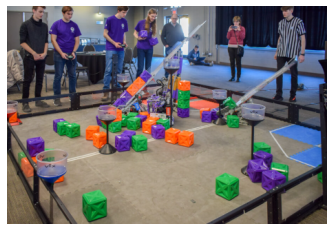

In [13]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

img = load_img('C://Users//rache//Downloads//dsbook//fig//vex.PNG')
print(img.mode) # RGB color channels 
print(img.size) # 465 x 316 pixels

# show the image
plt.imshow(img)
plt.axis('off')

In [5]:
img_array = img_to_array(img)
print("NumPy array info:") 
print(type(img_array))  
print(img_array)  
print(img_array.shape)  

NumPy array info:
<class 'numpy.ndarray'>
[[[126. 131. 138.]
  [129. 134. 140.]
  [129. 134. 140.]
  ...
  [  8.   3.  20.]
  [  5.   2.  17.]
  [  3.   2.  16.]]

 [[127. 132. 138.]
  [129. 134. 141.]
  [129. 134. 140.]
  ...
  [  8.   3.  21.]
  [  5.   3.  17.]
  [  4.   2.  14.]]

 [[128. 132. 140.]
  [130. 135. 141.]
  [130. 135. 141.]
  ...
  [  8.   4.  21.]
  [  6.   4.  18.]
  [  7.   5.  17.]]

 ...

 [[114.  96.  77.]
  [115.  96.  73.]
  [101.  83.  56.]
  ...
  [ 90.  77.  59.]
  [ 86.  73.  55.]
  [ 89.  76.  62.]]

 [[113.  95.  72.]
  [106.  88.  61.]
  [110.  92.  59.]
  ...
  [ 94.  82.  62.]
  [ 93.  80.  62.]
  [ 84.  71.  56.]]

 [[103.  86.  59.]
  [101.  78.  56.]
  [110.  84.  62.]
  ...
  [ 98.  86.  62.]
  [100.  88.  65.]
  [ 99.  86.  65.]]]
(316, 465, 3)


In [6]:
img_array = np.array(img_array, dtype=np.float64) / 255.0
img_array = img_array.reshape(316*465, 3)
img_array.shape

(146940, 3)

### \url{https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html}

### Reduce colors to just 16 colors using K-Means clutersing across the pixel space.

In [7]:
from sklearn.utils import shuffle
n_colors=16
codebook_random = shuffle(img_array, random_state=0)[:n_colors]
def recreate_image(codebook, labels, w, h):
   
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


In [8]:
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

kmeans = KMeans(n_clusters=n_colors, random_state=1).fit(img_array)
labels =kmeans.predict(img_array)
new_img = recreate_image(kmeans.cluster_centers_, labels, 316,465)


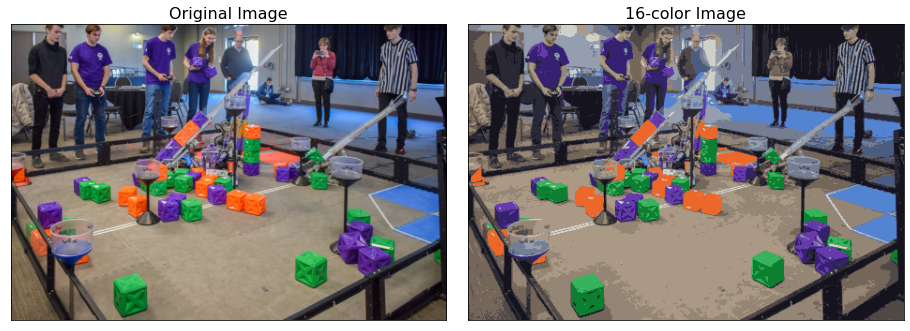

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(new_img)
ax[1].set_title('16-color Image', size=16)
#plt.savefig('vex_Compare_images_kmeans.png', dpi=72, bbox_inches='tight')

# Image processing con't
## Load large dataset from directories for deep learning in Keras

### Storing and structuring image dataset on disk are necessary so that they can be retrieved and generalized in a more efficient way. \textit{ImageDataGenerator} class in the Keras library provides a autonomous functionality of performing data augmentation. When training a neural networks, in which we will be doing soon, \textit{ImageDataGenerator} can benefit us inseveral ways. First, it can expand the datasets by transforming original dataset, such as rotating, zooming, width and height shifting, fliping the images etc. Second,  on-the-fly image batch manupulation; it allows for synchronizaion between generating new examples and training. It is the most commonly use for becuase model can be more generalized when we have new variations of our data at each and every epoch.

### Columbia Object Image Library (COIL 100) is a database of color images of 100 objects. The objects were placed on a motorized turntable against a black background The turntable was rotated through 360 degrees to vary object pose with respect to a fixed color camera Images of the objects were taken at pose intervals of 5 degrees This corresponds to 72 poses per objects The images were size normalized COIL100 is available online via ftp.


In [ ]:
### AUTOTUNE is a new face to us. It will automatically adjust the tf.data runtime to tune the value dynamically at runtime for the efficiency issue. However, in this level, let’s not waste our time to understand this

### pathlib is a module that offers classes representing filesystem paths with semantics appropriate for different operating systems. (from docs.python.org) directory

In [24]:
import pathlib
os.chdir('c:\\Users\\rache\\Downloads\\dsbook\\Data')
data_dir = os.path.join('coil_100')
data_dir= pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png'))) #data_dir.glob will scrap whatever it is in the data_dir.
class_name = os.listdir(data_dir)


In [25]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255 )
BATCH_SIZE =100
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = image_data_generator.flow_from_directory(directory=data_dir, batch_size=BATCH_SIZE, shuffle=True ,classes = list(class_name))

Found 216 images belonging to 3 classes.


In [28]:
from tensorflow.keras import preprocessing
image_data_generator = preprocessing.image.ImageDataGenerator(rescale=1./255,dtype='float32')
train_data_gen = image_data_generator.flow_from_directory(directory=data_dir, target_size = (28,28),
                                                              batch_size=100, shuffle=True,
                                                              classes = list(class_name))

Found 216 images belonging to 3 classes.


In [29]:

def train_images ():
    
    image_data_generator = preprocessing.image.ImageDataGenerator(rescale=1./255,dtype='float32')
    train_data_gen = image_data_generator.flow_from_directory(directory=data_dir, target_size = (28,28),
                                                             shuffle=True,color_mode='grayscale',
                                                              classes = list(class_name))
    return train_data_gen[0][0].astype('float32'), train_data_gen[0][1].astype('float32')

 

In [30]:
type(train_images()[0])

Found 216 images belonging to 3 classes.


numpy.ndarray

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D

In [35]:
list_files = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for image in list_files.take(3):
  print(image)


tf.Tensor(b'coil_100\\Dristan\\obj1__215.png', shape=(), dtype=string)
tf.Tensor(b'coil_100\\Johnson&Johnson\\obj64__210.png', shape=(), dtype=string)
tf.Tensor(b'coil_100\\Rolaids\\obj5__200.png', shape=(), dtype=string)


### Use Dataset.map to create a dataset of image, label pairs:

In [40]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return img


def get_label(file_path):
  # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
    return parts[-2] == class_name

def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label



In [131]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_data = list_files.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_data.take(10):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())




Image shape:  (128, 128, 3)
Label:  [False  True False]
Image shape:  (128, 128, 3)
Label:  [False False  True]
Image shape:  (128, 128, 3)
Label:  [False  True False]
Image shape:  (128, 128, 3)
Label:  [False False  True]
Image shape:  (128, 128, 3)
Label:  [ True False False]
Image shape:  (128, 128, 3)
Label:  [False  True False]
Image shape:  (128, 128, 3)
Label:  [False False  True]
Image shape:  (128, 128, 3)
Label:  [False  True False]
Image shape:  (128, 128, 3)
Label:  [False False  True]
Image shape:  (128, 128, 3)
Label:  [ True False False]


### The Keras Blog:  https://blog.keras.io/building-autoencoders-in-keras.html  Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

In [36]:

train_data_gen = image_data_generator.flow_from_directory(directory=data_dir,                           batch_size=BATCH_SIZE, shuffle=True ,classes = list(class_name))

image_batch, label_batch = next(iter(train_data_gen))
image_batch.shape

Found 216 images belonging to 3 classes.


(100, 256, 256, 3)

In [ ]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [43]:
def build_autoencoder (shape, size):
    encoder = Sequential()
    encoder.add(InputLayer(shape))
    encoder.add(Flatten())
    encoder.add (Dense(size))

    decoder = Sequential()
    decoder.add(InputLayer((size,)))
    decoder.add(Dense(np.prod(shape)))
    decoder.add(Reshape(shape))
    return encoder, decoder

In [44]:
encoder, decoder = build_autoencoder(input_shape_val, 32)

In [45]:
decoder


In [49]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten ,Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 


model = Sequential([Conv2D(16, 3, padding='same', activation='relu',input_shape=input_shape_val),

    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),

    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),

    MaxPooling2D(),

    Flatten(),

    Dense(512, activation='relu'),

    Dense(3)])

 

model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])


In [145]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 128)       18560     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 16384)           